# Load pretrain model

In [1]:
from Score_Matching import *
from FLIPD import *
import torch 
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
score_model = ScoreNet(
    image_dim=(1,28,28), 
    use_condition=True, 
    num_classes=10, 
    device = device
)

In [4]:
# Load model with lastest checkpoint
def find_last_folder():
    all_subdirs = ['./Score_Matching/checkpoints/' + d for d in os.listdir('./Score_Matching/checkpoints/') if os.path.isdir(os.path.join('./Score_Matching/checkpoints/', d))]
    return max(all_subdirs, key=os.path.getmtime)

last_checkpoint = find_last_folder()
print("Loading model from checkpoint: ", last_checkpoint)

score_model.model.load_state_dict(torch.load(last_checkpoint + '/model.pt', map_location=device))

Loading model from checkpoint:  ./Score_Matching/checkpoints/20250114-100745


<All keys matched successfully>

# Test model

In [ ]:
# # Sampling 
# sampler = Predictor_Corrector_Sampler(
#     score_model=score_model, 
#     signal_to_noise_ratio=0.16, 
#     device=device,
#     epsilon=1e-6
# )

# image_state = sampler.sample(
#     num_steps=100, 
#     batch_size=1, 
#     sample_condition=torch.tensor([0]).to(device)
# )

# # show image
# plt.imshow(image_state.squeeze().cpu().detach().numpy(), cmap='gray')

# Calculate FLIPD 

In [6]:
metric = FLIPD(
    score_model=score_model
)

In [15]:
batch_size = 1 
condition_label = [0]

x = torch.randn(batch_size, 1, 28, 28).to(device)
y = torch.tensor(condition_label).to(device)

time_steps = torch.linspace(1., 1e-6, 100)
step_size = time_steps[0] - time_steps[1]

image_state = x.clone()

flipd_hist = []

for step in tqdm(time_steps): 
    batch_time_step = torch.ones(batch_size, device=score_model.device) * step
    score = score_model.model(batch_time_step, image_state, y)
    score_norm = torch.norm(score.reshape(score.shape[0], -1), dim=-1).mean()
    
    # # Corrector step (Langevin MCMC)
    noise_norm = torch.sqrt(torch.prod(torch.tensor(image_state.shape[1:])))
    langevin_step_size = 2 * (0 * noise_norm / score_norm)**2
    image_state = image_state + langevin_step_size * score + torch.sqrt(2 * langevin_step_size) * torch.randn_like(image_state)
    
    # Predictor step (Euler-Maruyama)
    g = score_model.sde.sde(torch.zeros_like(image_state), batch_time_step)[1]
    x_mean = image_state + (g**2)[:, None, None, None] * score_model.model(batch_time_step, image_state, y) * step_size
    image_state = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(image_state)

100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


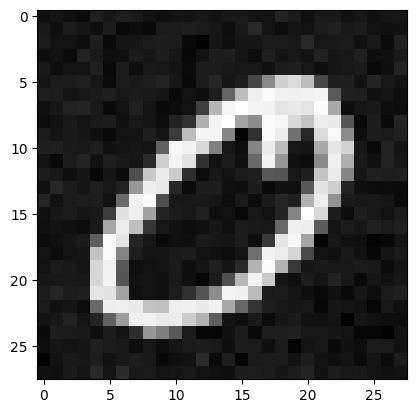

In [28]:
plt.imshow(x_mean.squeeze().cpu().detach().numpy(), cmap='gray')

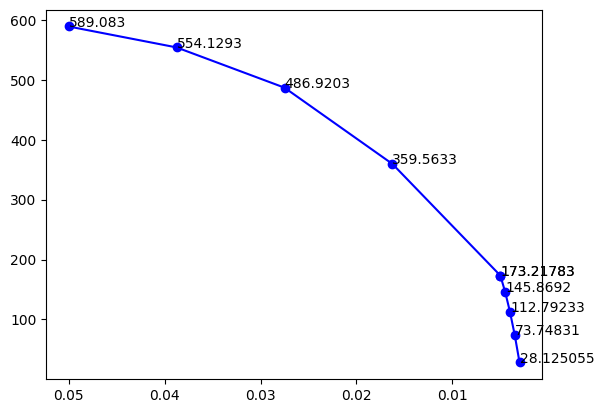

In [27]:
time_steps = list(np.linspace(0.003, 0.005, 5)) + list(np.linspace(0.005, 0.05, 5))
time_steps = list(reversed(time_steps))
flipd = []
for idx, step in enumerate(time_steps):
    t_0 = torch.ones(batch_size).to(device) * (step)
    flipd_score = metric.flipd(t_0, x_mean, y)[0].mean().detach().numpy()
    flipd.append(flipd_score)
    plt.text(step, flipd_score, str(flipd_score))

plt.plot(time_steps, flipd, '-o', color='blue')
plt.gca().invert_xaxis()  # Invert the x-axis
plt.xscale('linear')
plt.show()